In [2]:
# Import libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

c:\Users\bamik\.conda\envs\py\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Dimensions
latent_size = 64
hidden_size = 256
image_size = 784 # 28x28
num_epochs = 200
batch_size = 100
learning_rate = 0.0002
num_classes = 10

In [5]:
# Dataset transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [5]:
# Download MNIST dataset
mnist = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# Set dataloader
dataloader = torch.utils.data.DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True)

In [6]:
# Generator model
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_size, num_classes, hidden_size, image_size):
        super(ConditionalGenerator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_size + num_classes, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, image_size),
            nn.Tanh()
        )

    def forward(self, z, labels):
        # Concatenate noise (z) and label embeddings
        label_embeddings = self.label_embedding(labels)
        input = torch.cat([z, label_embeddings], dim=1)
        return self.model(input)

In [7]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes, hidden_size, image_size):
        super(ConditionalDiscriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(image_size + num_classes, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        # Concatenate image and label embeddings
        label_embeddings = self.label_embedding(labels)
        input = torch.cat([x, label_embeddings], dim=1)
        return self.model(input)

In [8]:
# Create Generator and Discriminator models
G = ConditionalGenerator(latent_size, num_classes, hidden_size, image_size).to(device)
D = ConditionalDiscriminator(num_classes, hidden_size, image_size).to(device)

In [9]:
# Optimization algorithm
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)
g_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)

In [10]:
# Real label
def real_labels(size):
    return torch.ones(size, 1).to(device)
    # return torch.full((size, 1), 0.9).to(device)

# Fake label
def fake_labels(size):
    return torch.zeros(size, 1).to(device)

Epoch [20/200], d_loss: 0.2167, g_loss: 5.5293


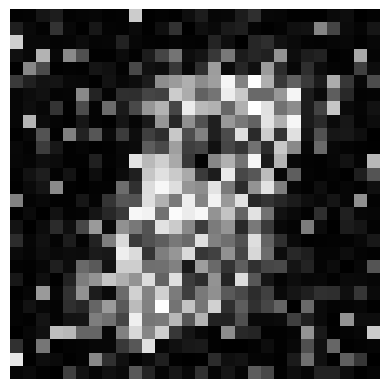

Epoch [40/200], d_loss: 0.6111, g_loss: 3.7702


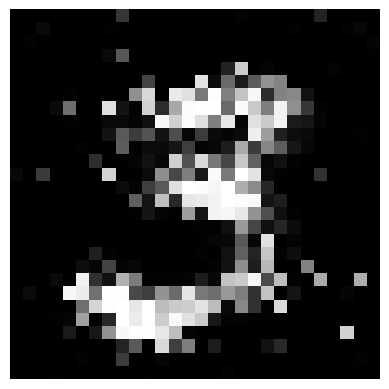

Epoch [60/200], d_loss: 0.5776, g_loss: 2.4771


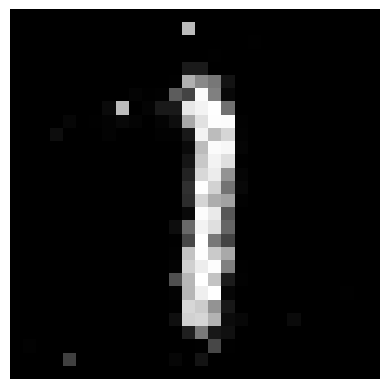

Epoch [80/200], d_loss: 0.7748, g_loss: 1.9139


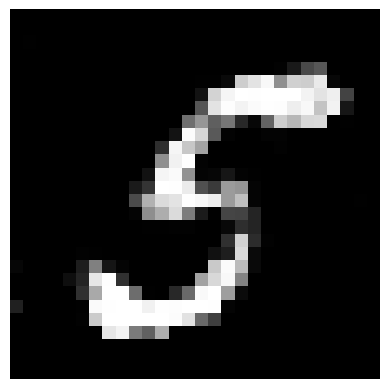

Epoch [100/200], d_loss: 1.0025, g_loss: 1.6397


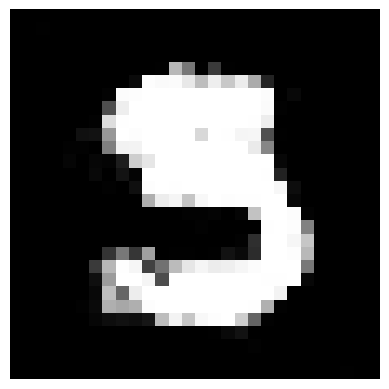

Epoch [120/200], d_loss: 1.0127, g_loss: 1.2419


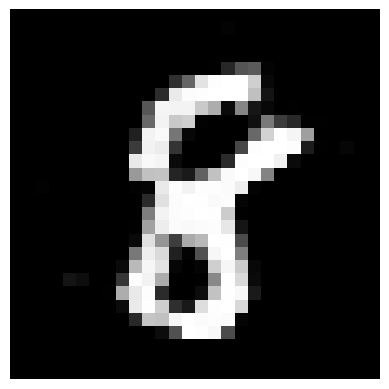

Epoch [140/200], d_loss: 1.1839, g_loss: 1.2458


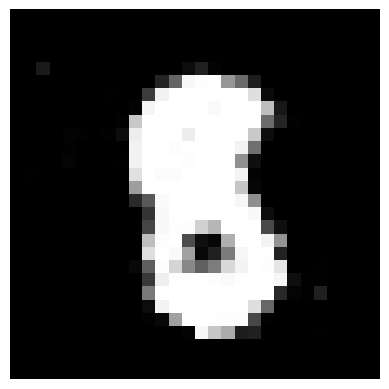

Epoch [160/200], d_loss: 0.8002, g_loss: 1.4887


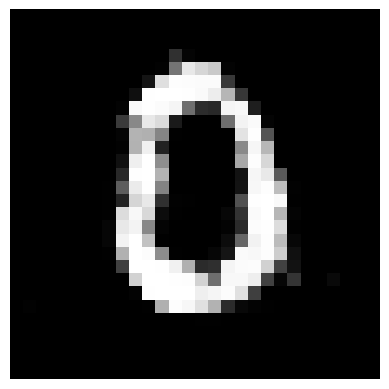

Epoch [180/200], d_loss: 1.0705, g_loss: 1.1983


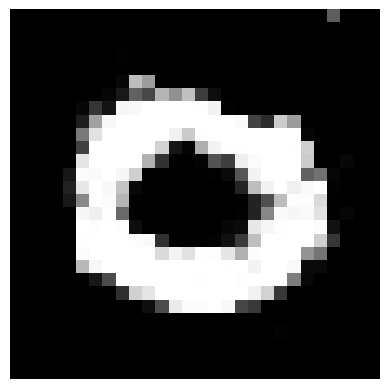

Epoch [200/200], d_loss: 0.9578, g_loss: 1.2264


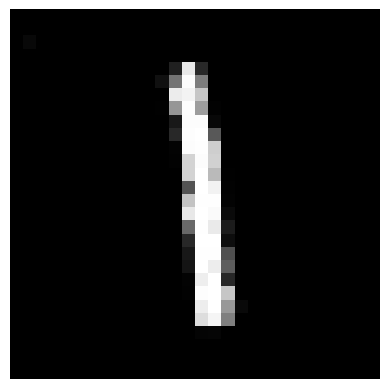

In [15]:
# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader):
        batch_size = images.size(0)

        # Flatten images to vectors and move to device
        images = images.reshape(batch_size, -1).to(device)
        labels = labels.to(device)  # Move labels (digits 0-9) to device
        
        # === Train Discriminator ===
        
        # Real images loss
        real = real_labels(batch_size)  # Real labels
        outputs_real = D(images, labels)  # Pass real images and labels to Discriminator
        d_loss_real = criterion(outputs_real, real)  # Compare with real labels

        # Fake images loss
        z = torch.randn(batch_size, latent_size).to(device)  # Random noise (latent vector)
        fake_images = G(z, labels)  # Generate fake images conditioned on the same labels
        fake = fake_labels(batch_size)  # Fake labels
        outputs_fake = D(fake_images, labels)  # Pass fake images and labels to Discriminator
        d_loss_fake = criterion(outputs_fake, fake)  # Compare with fake labels

        # Total Discriminator loss and backpropagation
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # === Train Generator ===
        
        # Generate fake images with new noise and labels
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z, labels)

        # Try to fool the discriminator: make it classify the fake images as real (real labels)
        outputs = D(fake_images, labels)
        g_loss = criterion(outputs, real_labels(batch_size))  # Labels are real here (trying to trick D)

        # Backpropagation for the generator
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    # Print the losses and periodically display generated images
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')
        
        # Display one generated image from the batch
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
        plt.imshow(fake_images[0].cpu().detach().numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.show()


In [16]:
# Save the generator and discriminator
torch.save(G.state_dict(), 'weight/mnist_cgan_generator.pth')
torch.save(D.state_dict(), 'weight/mnist_cgan_discriminator.pth')

print("Models saved successfully!")


Models saved successfully!


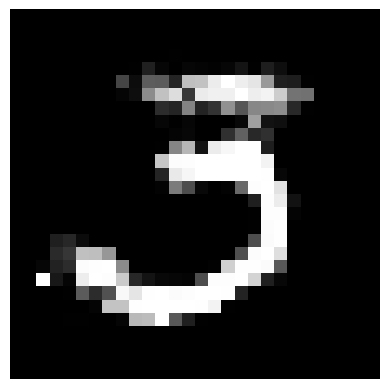

In [14]:


# Assuming the Conditional Generator is already defined and loaded

# Load the trained generator's parameters
G = ConditionalGenerator(latent_size=64, num_classes=10, hidden_size=256, image_size=784).to(device)
G.load_state_dict(torch.load('weight/mnist_cgan_generator.pth'))
G.eval()

# Generate random noise
latent_size = 64
num_samples = 1  # Number of images to generate
z = torch.randn(num_samples, latent_size).to(device)

# Specify the digit you want to generate (e.g., digit 3)
digit_to_generate = 3
labels = torch.tensor([digit_to_generate]).to(device)

# Generate the image for the specified digit
with torch.no_grad():
    generated_image = G(z, labels)

# Reshape and visualize the generated image
generated_image = generated_image.reshape(28, 28).cpu().numpy()

# Plot the generated image
plt.imshow(generated_image, cmap='gray')
plt.axis('off')
plt.show()

Digit to generate 0


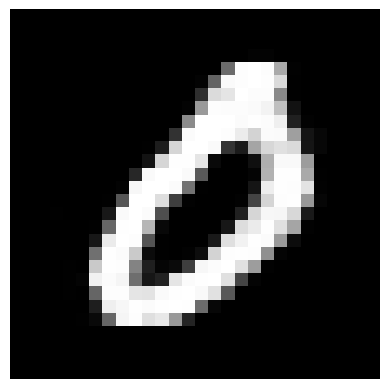

Digit to generate 1


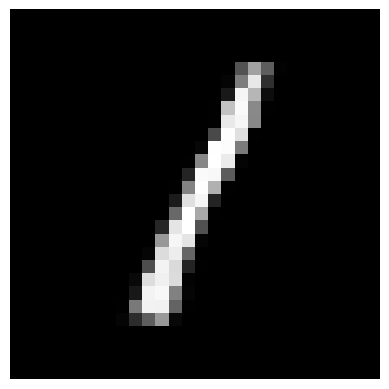

Digit to generate 2


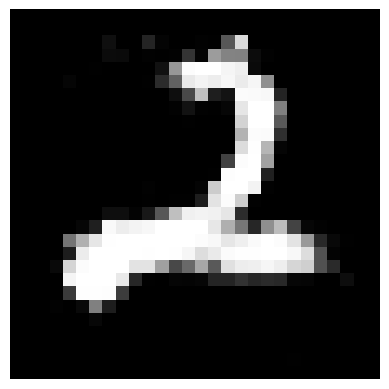

Digit to generate 3


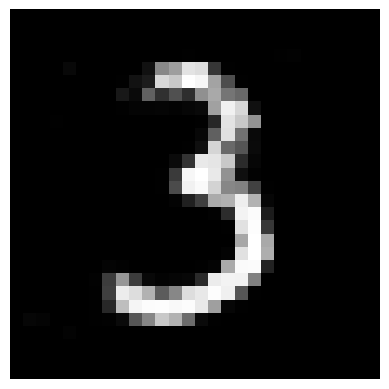

Digit to generate 4


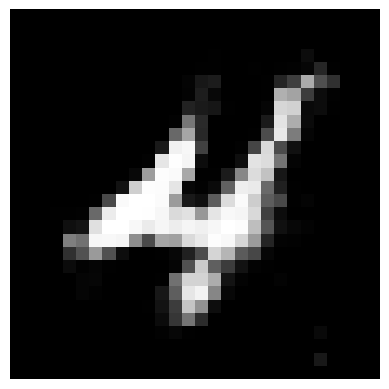

Digit to generate 5


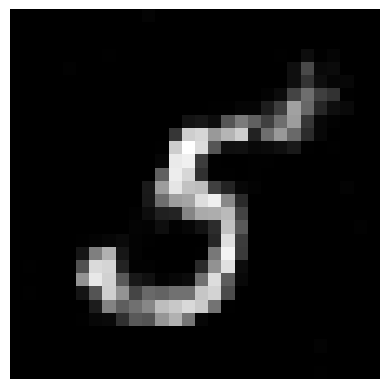

Digit to generate 6


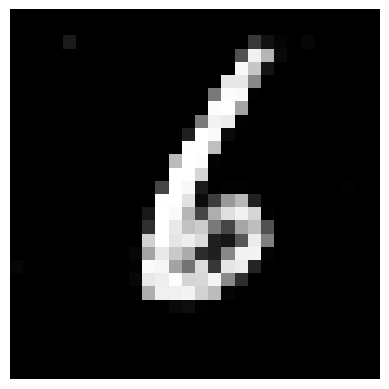

Digit to generate 7


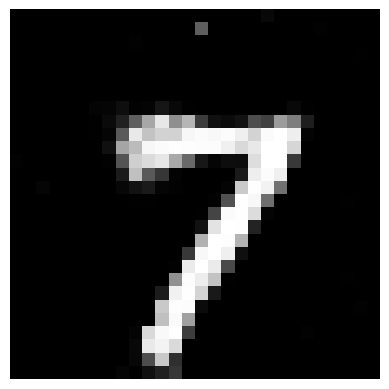

Digit to generate 8


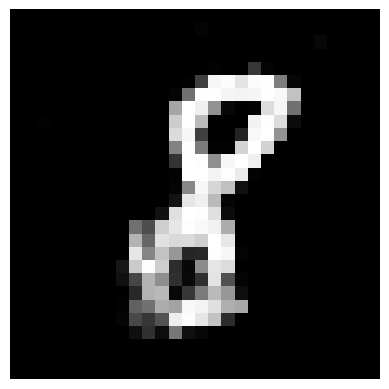

Digit to generate 9


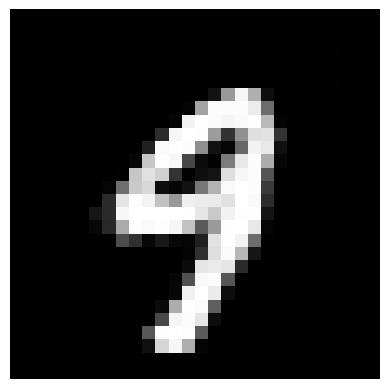

In [18]:
for i in range(10):
    # Specify the digit you want to generate (e.g., digit 3)
    digit_to_generate = i
    labels = torch.tensor([digit_to_generate]).to(device)

    # Generate the image for the specified digit
    with torch.no_grad():
        generated_image = G(z, labels)

    # Reshape and visualize the generated image
    generated_image = generated_image.reshape(28, 28).cpu().numpy()

    print(f'Digit to generate {i}')
    # Plot the generated image
    plt.imshow(generated_image, cmap='gray')
    plt.axis('off')
    plt.show()

### Evaluation

In [2]:
# Import libraries
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

c:\Users\bamik\.conda\envs\py\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Generator model
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_size, num_classes, hidden_size, image_size):
        super(ConditionalGenerator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_size + num_classes, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, image_size),
            nn.Tanh()
        )

    def forward(self, z, labels):
        # Concatenate noise (z) and label embeddings
        label_embeddings = self.label_embedding(labels)
        input = torch.cat([z, label_embeddings], dim=1)
        return self.model(input)

In [5]:
# Load the trained generator's parameters
G = ConditionalGenerator(latent_size=64, num_classes=10, hidden_size=256, image_size=784).to(device)
G.load_state_dict(torch.load('weight/mnist_cgan_generator.pth'))
G.eval()

# Generate random noise
latent_size = 64

In [6]:
def generate_digits(digits_to_generate):
    # Convert the multi-digit number into a list of individual digits
    digits_list = [int(digit) for digit in str(digits_to_generate)]

    generated_images = []

    # Generate an image for each individual digit
    for digit in digits_list:
        labels = torch.tensor([digit]).to(device)
        z = torch.randn(1, latent_size).to(device)  # Generate random noise for the generator

        with torch.no_grad():
            generated_image = G(z, labels)  # Generate image for the current digit

        # Reshape and store the generated image
        generated_image = generated_image.reshape(28, 28).cpu().numpy()
        generated_images.append(generated_image)

    # Concatenate the images horizontally to form a multi-digit sequence
    full_sequence_image = np.concatenate(generated_images, axis=1)  # Axis 1 = concatenate horizontally

    print(f'Digits to generate: {digits_to_generate}')
    
    # Plot the full multi-digit image
    plt.imshow(full_sequence_image, cmap='gray')
    plt.axis('off')
    plt.show()


Digits to generate: 1234567890


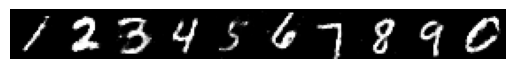

In [14]:
digit_to_generate = 1234567890
generate_digits(digit_to_generate)

Digits to generate: 101


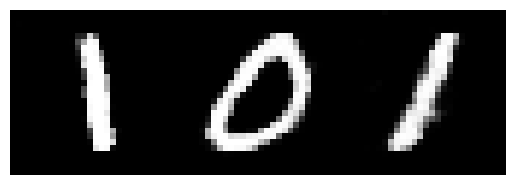

In [15]:
digit_to_generate = 101
generate_digits(digit_to_generate)

Digits to generate: 7950


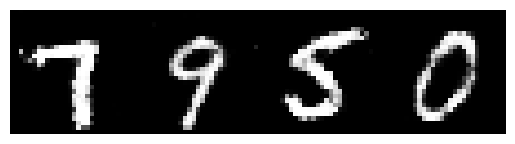

In [16]:
digit_to_generate = 7950
generate_digits(digit_to_generate)